In [1]:
import numpy as np 
import pandas as pd
import torch 
import matplotlib.pylab as plt 
from matplotlib import cm
import flowtorch.bijectors as bij
import flowtorch.distributions as dist
from getdist import plots, MCSamples
import getdist
import random 
import tqdm 
import emcee 
import os

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

color1 = "#50C878" 
color2 = "#222E50"
color3 = cm.tab10.colors[0]
settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}

In [19]:
class SampleLoader:
    def __init__(self, fname):
        df = pd.read_csv(f'samples/{fname}.csv', index_col=0)
        self.samples = df.values
        self.columns = list(df.columns)
        self.name = fname
    
    def __str__(self):
        return self.name
        
class TransForm:

    def __init__(self, samples):
        
        self.ndim = samples.shape[1]
        self.samples = samples
        self.cov_train = np.cov(samples.T)
        self.cholesky = np.linalg.cholesky(self.cov_train)
        self.cholesky_inv = np.linalg.inv(self.cholesky)
        self.mean = np.mean(samples, axis = 0).reshape(-1, self.ndim)
        
    def forward(self, testpoint):
        testpoint = testpoint.reshape(-1, self.ndim)
        testtrans = self.cholesky_inv @ (testpoint - self.mean).T
        return testtrans.T

    def inverse(self, prediction):
        prediction = prediction.reshape(-1, self.ndim)
        predtrans = self.cholesky @ prediction.T + self.mean.T
        return predtrans.T
        
def create_dataset(samples, nsamples=None):
    mean_np = np.median(samples, axis = 0)
    std_np = np.std(samples, axis = 0)
    
    if nsamples is not None:
        nsamples_original = samples.shape[0]
        idx = random.sample(range(1, nsamples_original), nsamples)
        samples = samples[idx]
        
    dataset = torch.tensor(samples, dtype=torch.float)
    mean = torch.tensor(mean_np, dtype=torch.float)
    std = torch.tensor(std_np, dtype=torch.float)
    return dataset, mean, std

def build_network(hidden=(32, 32, 32)):
    """Creates a function to do the mapping

    Args:
        hidden (tuple, optional): Number of hidden layers. Defaults to (32, 32, 32).

    Returns:
        flowtorch.lazy.lazy: a composition of bijectors
    """

    transforms = bij.Compose(
        bijectors=[
            bij.AffineAutoregressive(
                params.DenseAutoregressive(hidden_dims=hidden, nonlinearity=nn.Tanh),
            ),
            bij.AffineAutoregressive(
                params.DenseAutoregressive(hidden_dims=hidden, nonlinearity=nn.Tanh),
            ),
            bij.AffineAutoregressive(
                params.DenseAutoregressive(hidden_dims=hidden, nonlinearity=nn.Tanh),
            ),
        ]
    )
    return transforms
    
class NormFlow(TransForm, SampleLoader):
    def __init__(self, experiment: str, nsamples=None, nstd = 1):

        SampleLoader.__init__(self, experiment)
        TransForm.__init__(self, self.samples)
        data = TransForm.forward(self, self.samples)
        self.dataset, self.fiducial, self.std = create_dataset(data, nsamples)
        
        dist_x = torch.distributions.Independent(torch.distributions.Normal(self.fiducial, nstd*self.std), 1)
        bijector = build_network(hidden=(16, 16, 16))
        self.dist_y = dist.Flow(dist_x, bijector)
        
    def training(self, lr=5E-3, nsteps = 1000):
        optimizer = torch.optim.Adam(self.dist_y.parameters(), lr=lr)
        record = []
        with tqdm.trange(nsteps) as bar:
            for step in bar:
                optimizer.zero_grad()
                loss = -self.dist_y.log_prob(self.dataset).mean()
                loss.backward()
                optimizer.step()
                record.append(loss.item())
                postfix = dict(Loss=f"{loss.item():.3f}")
                bar.set_postfix(postfix)
        return record
            
    def generate_samples(self, nsamples):
        gen_samples = self.dist_y.sample(torch.Size([nsamples,])).detach().numpy()
        gen_samples = TransForm.inverse(self, gen_samples)
        return gen_samples

    def loglike(self, parameter):
        parameter = TransForm.forward(self, parameter)
        p_tensor = torch.tensor(parameter, dtype=torch.float)
        return self.dist_y.log_prob(p_tensor).detach().numpy() + np.log(np.linalg.det(self.cholesky_inv))

def build_flow(experiment, nsamples=None, lr=5E-3, nsteps=1000):
    flow = NormFlow(experiment, nsamples)
    loss = flow.training(lr, nsteps)
    os.makedirs('flows', exist_ok=True)
    torch.save(flow, f'flows/{experiment}.pt')
    return flow

def load_flow(experiment):
    flow = torch.load(f'flows/{experiment}.pt')
    return flow

def triangle_plot(samples1, samples2, label1, label2, fname):

    settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
    color1 = "#50C878" 
    color2 = "#222E50"
    
    ndim = 5
    names = ["x%s"%i for i in range(ndim)]
    labels = [
        r"$\sigma_{8}$",
        r"$\Omega_{c}$",
        r"$\Omega_{b}$",
        r"$h$",
        r"$n_{s}$"]
    
    samples_1 = MCSamples(samples=samples1, names = names, labels = labels, label = label1, settings = settings)
    samples_2 = MCSamples(samples=samples2, names = names, labels = labels, label = label2, settings = settings)
 
    G = plots.getSubplotPlotter(subplot_size=1.0)
    G.settings.solid_contour_palefactor = 0.9
    G.settings.alpha_filled_add = 0.9
    G.settings.num_plot_contours = 2
    G.settings.lw_contour = 1
    G.settings.axes_fontsize = 15
    G.settings.lab_fontsize = 15
    G.settings.fontsize = 35  # important for padding in x-axis
    G.settings.legend_fontsize = 15
    samples_1.updateSettings({"contours": [0.68, 0.95]})
    samples_2.updateSettings({"contoburs": [0.68, 0.95]})
    G.triangle_plot(
        [samples_1, samples_2],
        filled=[True, False],
        contour_colors=[color1, color2],
        contour_lws=[2, 2],
        contour_ls=["-", "-"],
    )
    os.makedirs('plots', exist_ok=True)
    plt.savefig(f'plots/{fname}.pdf', transparent = False, bbox_inches = 'tight')
    plt.close()

In [12]:
DES_flow = build_flow('oxford_des_y1', nsamples=15000, nsteps = 1000)

100%|██████████████████████████████████████████████████████████████| 1000/1000 [05:01<00:00,  3.32it/s, Loss=6.455]


In [13]:
DES_flow_samples = DES_flow.generate_samples(50000)

In [14]:
ndim = 5
names = ["x%s"%i for i in range(ndim)]
labels = [
    r"$\sigma_{8}$",
    r"$\Omega_{c}$",
    r"$\Omega_{b}$",
    r"$h$",
    r"$n_{s}$"]
samples_1 = MCSamples(samples=DES_flow.samples,names = names, labels = labels, label = 'DES Y1', settings = settings)
samples_2 = MCSamples(samples=DES_flow_samples,names = names, labels = labels, label='DES Y1 (Flow)', settings = settings)

Removed no burn in
Removed no burn in


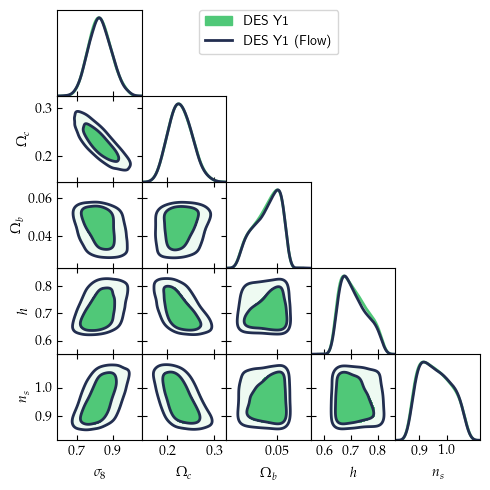

In [15]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_1.updateSettings({"contours": [0.68, 0.95]})
samples_2.updateSettings({"contoburs": [0.68, 0.95]})
G.triangle_plot(
    [samples_1, samples_2],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2, 2],
    contour_ls=["-", "-"],
)
# plt.savefig('plots/triangle_plot_comparison_des.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

# Planck 

In [47]:
Planck_flow=build_flow('base_plikHM_TTTEEE_lowl_lowE', nsamples=15000, nsteps = 1000)

100%|██████████████████████████████████████████████████████████████| 1000/1000 [05:56<00:00,  2.80it/s, Loss=6.629]


In [48]:
Planck_flow_samples = Planck_flow.generate_samples(50000)

In [49]:
samples_1_planck = MCSamples(samples=Planck_flow.samples,names = names, labels = labels, label = 'Planck', settings = settings)
samples_2_planck = MCSamples(samples=Planck_flow_samples,names = names, labels = labels, label='Planck (Flow)', settings = settings)

Removed no burn in
Removed no burn in


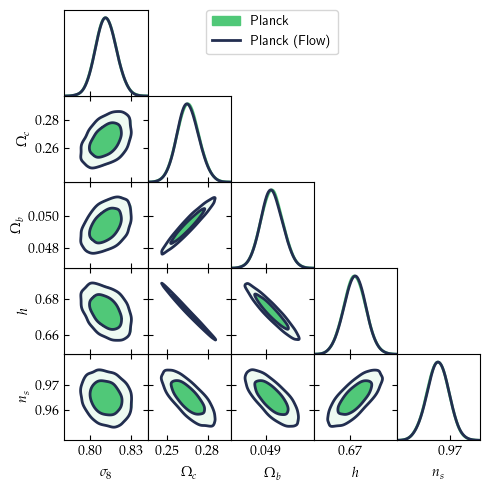

In [50]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_1.updateSettings({"contours": [0.68, 0.95]})
samples_2.updateSettings({"contoburs": [0.68, 0.95]})
G.triangle_plot(
    [samples_1_planck, samples_2_planck],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2, 2],
    contour_ls=["-", "-"],
)
# plt.savefig('plots/triangle_plot_comparison_des.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

## KiDS-1000

In [20]:
kids_1000_flow=build_flow('hybrid_kids_1000', nsteps = 1000)

100%|██████████████████████████████████████████████████████████████| 1000/1000 [01:42<00:00,  9.80it/s, Loss=5.608]


In [21]:
kids_1000_flow_samples = kids_1000_flow.generate_samples(50000)

In [22]:
K1K_samples = MCSamples(samples=kids_1000_flow.samples, 
                        names = names, 
                        labels = labels, 
                        label='KiDS-1000', 
                        settings = settings)

K1K_samples_flow = MCSamples(samples=kids_1000_flow_samples, 
                             names = names, 
                             labels = labels, 
                             label='KiDS-1000 (Flow)', 
                             settings = settings)

Removed no burn in
Removed no burn in


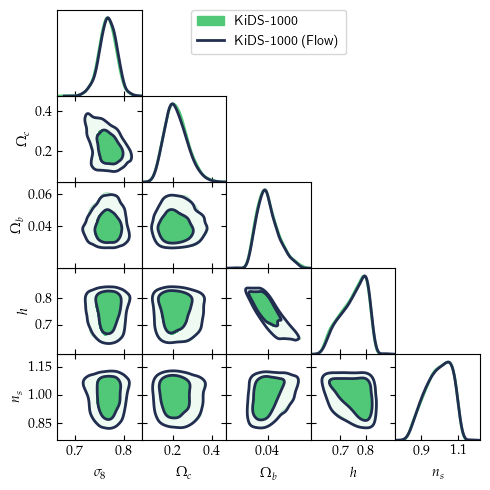

In [23]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
K1K_samples.updateSettings({"contours": [0.68, 0.95]})
K1K_samples_flow.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [K1K_samples, K1K_samples_flow],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2,2],
    contour_ls=["-", "-"],
)
# plt.savefig('plots/triangle_plot_comparison_des.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

## DES Y3

In [24]:
des_y3_flow = build_flow('hybrid_des_y3', nsteps = 1000)

100%|██████████████████████████████████████████████████████████████| 1000/1000 [01:50<00:00,  9.09it/s, Loss=5.546]


In [25]:
des_y3_flow_samples = des_y3_flow.generate_samples(50000)

In [26]:
DES_Y3_samples = MCSamples(samples=des_y3_flow.samples, 
                           names = names, 
                           labels = labels, 
                           label='DES Y3', 
                           settings = settings)

DES_Y3_samples_flow = MCSamples(samples=des_y3_flow_samples, 
                                 names = names, 
                                 labels = labels, 
                                 label='DES Y3 (Flow)', 
                                 settings = settings)

Removed no burn in
Removed no burn in


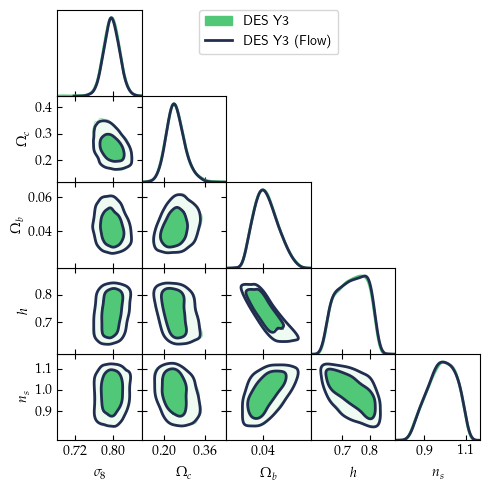

In [27]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
K1K_samples.updateSettings({"contours": [0.68, 0.95]})
K1K_samples_flow.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [DES_Y3_samples, DES_Y3_samples_flow],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2,2],
    contour_ls=["-", "-"],
)
# plt.savefig('plots/triangle_plot_comparison_des.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

# Joint

In [28]:
def loglike_flows(sample, flows):
    keys = list(flows.keys())
    logl = sum([flows[key].loglike(sample) for key in keys])
    return logl
    
class SampleFlow:
    def __init__(self, experiments: list):
        self.flows = {e:load_flow(e) for e in experiments}
        self.nexp = len(self.flows)
        self.mean = self.flows[experiments[0]].samples.mean(0) 
        self.ndim = len(self.mean)
        self.nwalkers = 2 * self.ndim
        
    def sampler(self, nsamples, eps = 1E-3):
        pos = self.mean + eps * np.random.randn(self.nwalkers, self.ndim)
        sampler = emcee.EnsembleSampler(self.nwalkers, self.ndim, loglike_flows, args=(self.flows,))
        sampler.run_mcmc(pos, nsamples, progress=True)
        return sampler

In [64]:
exp_1 = 'base_plikHM_TTTEEE_lowl_lowE' # 'hybrid_kids_1000' # 
exp_2 = 'oxford_des_y1' # 'hybrid_des_y3'# 'oxford_des_y1'
joint_flow = SampleFlow([exp_1, exp_2])

In [65]:
# sampler_flow = joint_flow.sampler(nsamples=10000)

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [24:39<00:00,  6.76it/s]


In [66]:
samples_flow = sampler_flow.get_chain(discard = 1000, flat=True)

# Hybrid DES Y3 + KiDS-1000

In [382]:
def diff_gaussians(samples_1, samples_2):
    mu_1 = np.mean(samples_1, axis = 0)
    mu_2 = np.mean(samples_2, axis = 0)
    std_1 = np.std(samples_1, axis = 0)
    std_2 = np.std(samples_2, axis = 0)
    error = np.abs(mu_1 - mu_2) / np.sqrt(std_1**2 + std_2**2)
    delta = '\u03B4'
    names_delta = [f'{delta}(sigma_8)', f'{delta}(Omega_cdm)', f'{delta}(Omega_b)', f'{delta}(h)', f'{delta}(n_s)']
    names = ['sigma_8', 'Omega_cdm', 'Omega_b', 'h', 'n_s']
    for i in range(5):
        print(f'{names_delta[i]:<15}: {error[i]:.3f}')

    print('-'*50)
    print('Samples 1')
    for i in range(5):
        print(f'{names[i]:<15}: {mu_1[i]:.4f} \u00B1 {std_1[i]:.4f}')
    print('-'*50)
    print('Samples 2')
    for i in range(5):
        print(f'{names[i]:<15}: {mu_2[i]:.4f} \u00B1 {std_2[i]:.4f}')

In [392]:
hybrid_des_kids = np.loadtxt('originalsamples/known-cross/chain_desy3_and_kids1000_hybrid_analysis.txt')[:,[22, 18, 19, 20, 21]]
hybrid_des_kids[:,1] = hybrid_des_kids[:,1] / hybrid_des_kids[:,3]**2
hybrid_des_kids[:,2] = hybrid_des_kids[:,2] / hybrid_des_kids[:,3]**2
hybrid_samples_known = hybrid_des_kids[len(hybrid_des_kids)//2:]

samples_known = MCSamples(samples=hybrid_samples_known, 
                           names = names, 
                           labels = labels, 
                           label='KiDS 1000 + DES Y3 (Known)', 
                           settings = settings)

Removed no burn in


In [393]:
sampler_flow = dill_load('mcmcsamples', 'hybrid_des_y3_kids_1000')
samples_flow = sampler_flow.get_chain(discard = 500, flat = True)

samples_joint = MCSamples(samples=samples_flow, 
                          names = names, 
                          labels = labels, 
                          label='KiDS 1000 + DES Y3 (Flow)', 
                          settings = settings)

Removed no burn in


In [394]:
diff_gaussians(hybrid_samples_known, samples_flow)

δ(sigma_8)     : 0.100
δ(Omega_cdm)   : 0.021
δ(Omega_b)     : 0.029
δ(h)           : 0.081
δ(n_s)         : 0.124
--------------------------------------------------
Samples 1
sigma_8        : 0.7822 ± 0.0147
Omega_cdm      : 0.2319 ± 0.0343
Omega_b        : 0.0407 ± 0.0064
h              : 0.7459 ± 0.0476
n_s            : 0.9754 ± 0.0635
--------------------------------------------------
Samples 2
sigma_8        : 0.7841 ± 0.0120
Omega_cdm      : 0.2310 ± 0.0282
Omega_b        : 0.0405 ± 0.0065
h              : 0.7512 ± 0.0443
n_s            : 0.9859 ± 0.0571


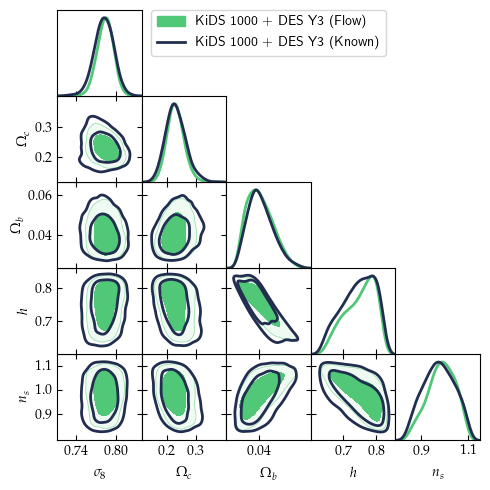

In [304]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_0.updateSettings({"contours": [0.68, 0.95]})
samples_joint.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [samples_joint, samples_known],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2, 2],
    contour_ls=["-", "-"],
)
# plt.savefig('plots/triangle_plot_comparison_public_kids_1000_des_y3.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

# FD and Planck 2018

In [305]:
COLS = ['sigma8', 'Omega_cdm', 'Omega_b', 'h', 'n_s'] 

In [306]:
from src.utils import dill_load

In [395]:
joint_flow = dill_load('mcmcsamples', 'P18_FD')
joint_flow_samples = joint_flow.get_chain(flat=True, discard=500)

In [396]:
def process_samples_FD_P18(save=False, burnin=None, thin=None):

    fname = 'FD_Garcia-Garcia2021_dzMarg_mMarg_P18_lcdm_nu' 
    columns = [43, 3, 4, 5, 6]
    record = []
    for i in range(4):
        samples = np.loadtxt(f'originalsamples/{fname}/{fname}.{i+1}.txt')
        cosmologies = samples[:,columns]
        if burnin is not None:
            start = int(cosmologies.shape[0] * burnin)
            cosmologies = cosmologies[start:]
        if thin is not None:
            cosmologies = cosmologies[0::thin]
        record.append(cosmologies)
    record = np.concatenate(record)
    df = pd.DataFrame(record, columns=COLS)
    print(f'Total number of samples for Oxford Full Dataset + Planck is: {df.shape[0]}')
    if save:
        df.to_csv(f'samples/{fname}.csv')
    return df

In [397]:
joint_known = process_samples_FD_P18(save=False, burnin=0.5)

Total number of samples for Oxford Full Dataset + Planck is: 23120


In [398]:
joint_known.head()

,sigma8,Omega_cdm,Omega_b,h,n_s
0,0.808671,0.257774,0.048797,0.679010,0.966592
1,0.808671,0.257774,0.048797,0.679010,0.966592
2,0.808922,0.257385,0.048750,0.679641,0.971857
3,0.807553,0.252118,0.048270,0.684222,0.973819
4,0.806539,0.249845,0.048033,0.685979,0.974790


In [399]:
diff_gaussians(joint_known.values, joint_flow_samples)

δ(sigma_8)     : 0.291
δ(Omega_cdm)   : 0.214
δ(Omega_b)     : 0.159
δ(h)           : 0.212
δ(n_s)         : 0.041
--------------------------------------------------
Samples 1
sigma_8        : 0.8042 ± 0.0051
Omega_cdm      : 0.2568 ± 0.0043
Omega_b        : 0.0486 ± 0.0004
h              : 0.6798 ± 0.0036
n_s            : 0.9689 ± 0.0037
--------------------------------------------------
Samples 2
sigma_8        : 0.8021 ± 0.0051
Omega_cdm      : 0.2580 ± 0.0037
Omega_b        : 0.0487 ± 0.0004
h              : 0.6787 ± 0.0031
n_s            : 0.9691 ± 0.0038


In [312]:
ndim = 5
names = ["x%s"%i for i in range(ndim)]
labels = [
    r"$\sigma_{8}$",
    r"$\Omega_{c}$",
    r"$\Omega_{b}$",
    r"$h$",
    r"$n_{s}$"]

samples_flow = MCSamples(samples=joint_flow_samples, 
                           names = names, 
                           labels = labels, 
                           label='Full Dataset + Planck 2018 (Flow)', 
                           settings = settings)

samples_known = MCSamples(samples=joint_known.values, 
                          names = names, 
                          labels = labels, 
                          label='Full Dataset + Planck 2018 (Known)', 
                          settings = settings)

Removed no burn in
Removed no burn in


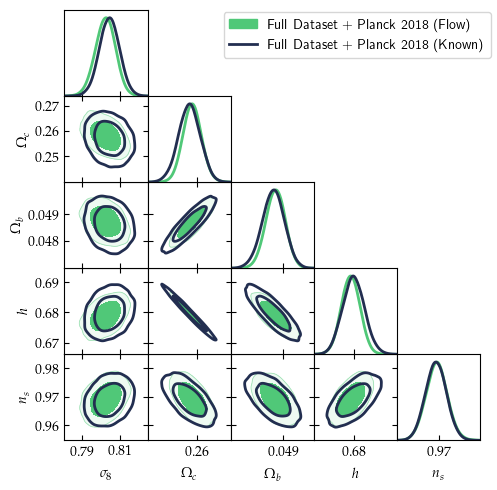

In [313]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_flow.updateSettings({"contours": [0.68, 0.95]})
samples_known.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [samples_flow, samples_known],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2, 2],
    contour_ls=["-", "-"],legend_loc=(0.45, 0.88)
)
# plt.savefig('plots/triangle_plot_comparison_fd_p18.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

## Check log-likelihood

In [314]:
def load_flow(experiment: str):
    """Load a pre-trained normalising flow.

    Args:
        experiment (str): name of the experiment (flow)

    Returns:
        NormFlow: the pre-trained normalising flow
    """
    fullpath = f"flows/{experiment}.pt"
    flow = torch.load(fullpath)
    return flow

In [315]:
p18_flow = load_flow('P18_lcdm_nu')
fd_flow = load_flow('FD_Garcia-Garcia2021_dzMarg_mMarg_nu')

In [316]:
grid = np.linspace(0.75, 0.83, 500)

In [317]:
record_l1 = []
record_l2 = []
record_tot = []
for v in grid:
    point = np.copy(joint_known.values[123])
    point[0] = v
    l1 = p18_flow.loglike(point).item()
    l2 = fd_flow.loglike(point).item()
    record_l1.append(l1)
    record_l2.append(l2)
    record_tot.append(l1 + l2)

In [318]:
pdf_l1 = np.exp(record_l1)
pdf_l2 = np.exp(record_l2)
pdf_tot = np.exp(record_tot)

pdf_l1 /= np.trapz(pdf_l1, grid)
pdf_l2 /= np.trapz(pdf_l2, grid)
pdf_tot /= np.trapz(pdf_tot, grid)

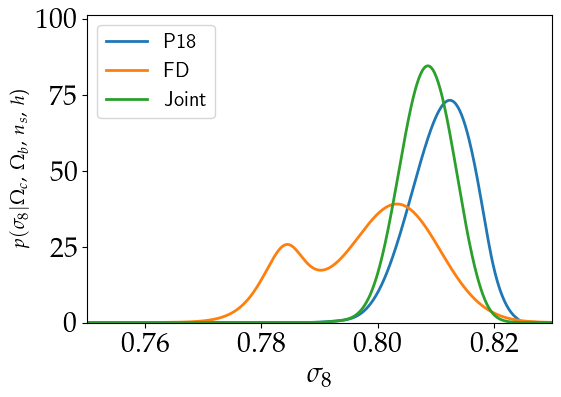

In [335]:
plt.figure(figsize=(6,4))
plt.plot(grid, pdf_l1, label = 'P18', lw = 2)
plt.plot(grid, pdf_l2, label = 'FD', lw=2)
plt.plot(grid, pdf_tot, label = 'Joint',lw=2)
plt.ylabel(r'$p(\sigma_{8}|\Omega_{c},\,\Omega_{b},\,n_{s},\,h$)', fontsize = fontSize-6)
plt.xlabel(r'$\sigma_{8}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})
plt.ylim(0.0, 1.2*max([max(pdf_l1), max(pdf_l2), max(pdf_tot)]))
plt.xlim(min(grid), max(grid))
# plt.savefig('plots/slice_density.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

# DES Y3 and KiDS-1000

In [320]:
from src.utils import dill_load

In [321]:
COLS = ['sigma8', 'Omega_cdm', 'Omega_b', 'h', 'n_s'] 

In [400]:
joint_flow = dill_load('mcmcsamples/', 'K1000_DESY3')
joint_flow_samples = joint_flow.get_chain(flat=True, discard=500)

In [401]:
def process_samples_kids_1000_des_y3(save=False, burnin=None, thin=None):

    fname = 'desy3wl_k1000_baryons_nocuts_nla_nside4096_lmax4500_lmin20_lmin100_GNG' 
    columns = [38, 37, 4, 5, 6]
    record = []
    for i in range(4):
        samples = np.loadtxt(f'originalsamples/{fname}/{fname}.{i+1}.txt')
        cosmologies = samples[:,columns]
        if burnin is not None:
            start = int(cosmologies.shape[0] * burnin)
            cosmologies = cosmologies[start:]
        if thin is not None:
            cosmologies = cosmologies[0::thin]
        record.append(cosmologies)
    record = np.concatenate(record)
    df = pd.DataFrame(record, columns=COLS)
    print(f'Total number of samples for Oxford KiDS-1000 and DES Y3 is: {df.shape[0]}')
    if save:
        df.to_csv(f'samples/{fname}.csv')
    return df

In [402]:
joint_known = process_samples_kids_1000_des_y3(save=False, burnin=0.5)

Total number of samples for Oxford KiDS-1000 and DES Y3 is: 274886


In [403]:
joint_known.head()

,sigma8,Omega_cdm,Omega_b,h,n_s
0,0.996749,0.154125,0.036410,0.798234,0.953315
1,0.996802,0.152118,0.035545,0.804833,0.946267
2,0.996802,0.152118,0.035545,0.804833,0.946267
3,0.996802,0.152118,0.035545,0.804833,0.946267
4,0.995735,0.158730,0.032949,0.838095,0.940186


In [404]:
diff_gaussians(joint_known.values, joint_flow_samples)

δ(sigma_8)     : 0.098
δ(Omega_cdm)   : 0.048
δ(Omega_b)     : 0.115
δ(h)           : 0.072
δ(n_s)         : 0.055
--------------------------------------------------
Samples 1
sigma_8        : 0.8930 ± 0.0653
Omega_cdm      : 0.1841 ± 0.0330
Omega_b        : 0.0431 ± 0.0091
h              : 0.7497 ± 0.0850
n_s            : 0.9780 ± 0.0521
--------------------------------------------------
Samples 2
sigma_8        : 0.9018 ± 0.0605
Omega_cdm      : 0.1820 ± 0.0298
Omega_b        : 0.0417 ± 0.0085
h              : 0.7414 ± 0.0769
n_s            : 0.9741 ± 0.0477


In [327]:
ndim = 5
names = ["x%s"%i for i in range(ndim)]
labels = [
    r"$\sigma_{8}$",
    r"$\Omega_{c}$",
    r"$\Omega_{b}$",
    r"$h$",
    r"$n_{s}$"]

samples_flow = MCSamples(samples=joint_flow_samples, 
                           names = names, 
                           labels = labels, 
                           label='KiDS-1000+DES Y3 (Flow)', 
                           settings = settings)

samples_known = MCSamples(samples=joint_known.values, 
                          names = names, 
                          labels = labels, 
                          label='KiDS-1000+DES Y3 (Known)', 
                          settings = settings)

Removed no burn in
Removed no burn in


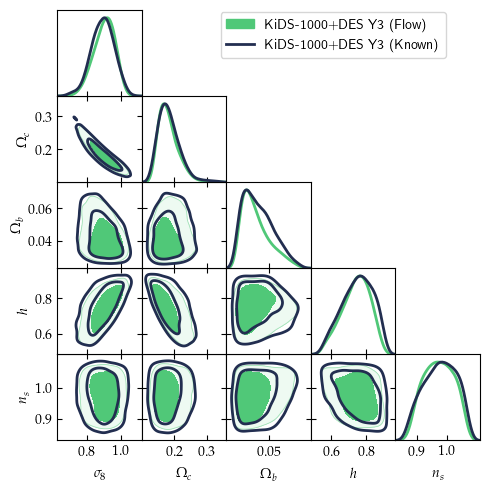

In [328]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_flow.updateSettings({"contours": [0.68, 0.95]})
samples_known.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [samples_flow, samples_known],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2, 2],
    contour_ls=["-", "-"],legend_loc=(0.45, 0.88)
)
# plt.savefig('plots/triangle_plot_carlos_kids_1000_des_y3.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

# Planck 2018 + DES Y3 + KiDS-1000

In [329]:
def process_oxford_planck_2018(save=False, burnin=None, thin = None):
    fname = 'P18_lcdm_nu'
    columns = [30, 3, 4, 5, 6]
    record = []
    for i in range(6):
        samples = np.loadtxt(f'originalsamples/{fname}/{fname}.{i+1}.txt')
        cosmologies = samples[:,columns]
        if burnin is not None:
            start = int(cosmologies.shape[0] * burnin)
            cosmologies = cosmologies[start:]
        if thin is not None:
            cosmologies = cosmologies[0::thin]
        record.append(cosmologies)
    record = np.concatenate(record)
    df = pd.DataFrame(record, columns=COLS)
    print(f'Total number of samples for Oxford Planck 2018 is: {df.shape[0]}')
    if save:
        df.to_csv(f'samples/{fname}.csv')
    return df

In [330]:
planck_samples = process_oxford_planck_2018(save=False, burnin=0.5)

Total number of samples for Oxford Planck 2018 is: 23218


In [386]:
joint_flow = dill_load('mcmcsamples/', 'P18_K1000_DESY3')
joint_flow_samples = joint_flow.get_chain(flat=True, discard=500)

In [387]:
ndim = 5
names = ["x%s"%i for i in range(ndim)]
labels = [
    r"$\sigma_{8}$",
    r"$\Omega_{c}$",
    r"$\Omega_{b}$",
    r"$h$",
    r"$n_{s}$"]

samples_flow = MCSamples(samples=joint_flow_samples, 
                           names = names, 
                           labels = labels, 
                           label='Planck 2018 + KiDS-1000 + DES Y3 (Flow)', 
                           settings = settings)

samples_known = MCSamples(samples=planck_samples.values, 
                          names = names, 
                          labels = labels, 
                          label='Planck 2018 (Known)', 
                          settings = settings)

Removed no burn in
Removed no burn in


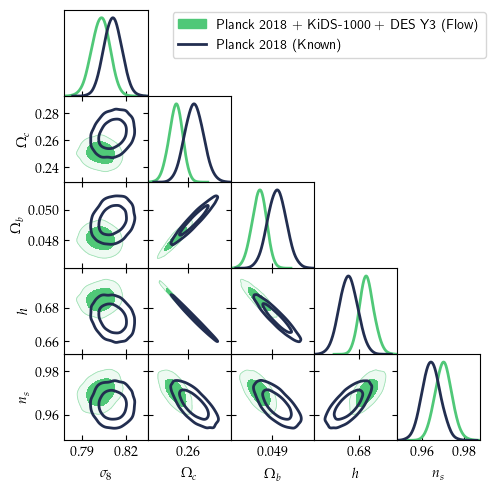

In [333]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_flow.updateSettings({"contours": [0.68, 0.95]})
samples_known.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [samples_flow, samples_known],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2, 2],
    contour_ls=["-", "-"],legend_loc=(0.35, 0.88)
)
# plt.savefig('plots/triangle_plot_p18_kids_1000_des_y3.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

# Public Planck 2018 + DES Y3 + KiDS-1000

In [388]:
planck_samples = pd.read_csv('samples/base_plikHM_TTTEEE_lowl_lowE.csv', index_col=0)

In [389]:
joint_flow = dill_load('mcmcsamples', 'Public_P18_K1000_DESY3')
joint_flow_samples_public = joint_flow.get_chain(flat=True, discard=500)

In [377]:
ndim = 5
names = ["x%s"%i for i in range(ndim)]
labels = [
    r"$\sigma_{8}$",
    r"$\Omega_{c}$",
    r"$\Omega_{b}$",
    r"$h$",
    r"$n_{s}$"]

samples_flow = MCSamples(samples=joint_flow_samples_public, 
                           names = names, 
                           labels = labels, 
                           label='Planck 2018 + KiDS-1000 + DES Y3 (Flow)', 
                           settings = settings)

samples_known = MCSamples(samples=planck_samples.values, 
                          names = names, 
                          labels = labels, 
                          label='Planck 2018 (Known)', 
                          settings = settings)

Removed no burn in
Removed no burn in


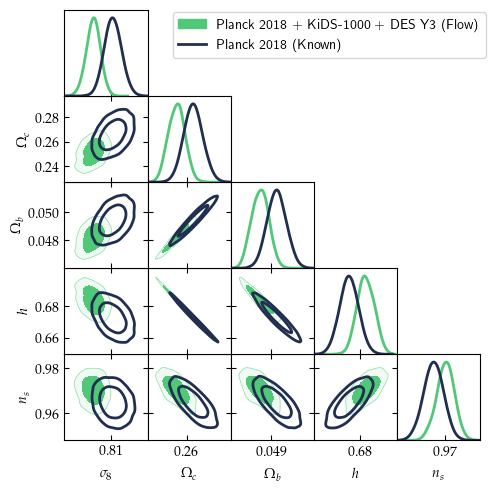

In [347]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 15
samples_flow.updateSettings({"contours": [0.68, 0.95]})
samples_known.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [samples_flow, samples_known],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2, 2],
    contour_ls=["-", "-"],legend_loc=(0.35, 0.88)
)
# plt.savefig('plots/triangle_plot_public_p18_kids_1000_des_y3.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

# Oxford and Public

In [390]:
diff_gaussians(joint_flow_samples_public, joint_flow_samples)

δ(sigma_8)     : 0.947
δ(Omega_cdm)   : 0.130
δ(Omega_b)     : 0.119
δ(h)           : 0.158
δ(n_s)         : 0.021
--------------------------------------------------
Samples 1
sigma_8        : 0.7948 ± 0.0061
Omega_cdm      : 0.2516 ± 0.0068
Omega_b        : 0.0482 ± 0.0006
h              : 0.6838 ± 0.0056
n_s            : 0.9703 ± 0.0040
--------------------------------------------------
Samples 2
sigma_8        : 0.8029 ± 0.0061
Omega_cdm      : 0.2505 ± 0.0052
Omega_b        : 0.0481 ± 0.0005
h              : 0.6849 ± 0.0044
n_s            : 0.9704 ± 0.0040


In [380]:
ndim = 5
names = ["x%s"%i for i in range(ndim)]
labels = [
    r"$\sigma_{8}$",
    r"$\Omega_{c}$",
    r"$\Omega_{b}$",
    r"$h$",
    r"$n_{s}$"]

samples_flow = MCSamples(samples=joint_flow_samples, 
                           names = names, 
                           labels = labels, 
                           label='Planck 2018 + KiDS-1000 + DES Y3 (Flow, Oxford)', 
                           settings = settings)

samples_flow_public = MCSamples(samples=joint_flow_samples_public, 
                          names = names, 
                          labels = labels, 
                          label='Planck 2018 + KiDS-1000 + DES Y3 (Flow, Public)', 
                          settings = settings)

Removed no burn in
Removed no burn in


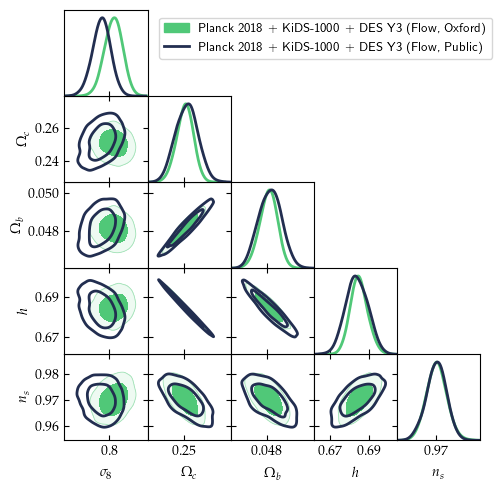

In [381]:
G = plots.getSubplotPlotter(subplot_size=1.0)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.9
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  # important for padding in x-axis
G.settings.legend_fontsize = 14
samples_flow.updateSettings({"contours": [0.68, 0.95]})
samples_flow_public.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot(
    [samples_flow, samples_flow_public],
    filled=[True, False],
    contour_colors=[color1, color2],
    contour_lws=[2, 2],
    contour_ls=["-", "-"],legend_loc=(0.32, 0.88)
)
# plt.savefig('plots/triangle_plot_public_oxford_p18_kids_1000_des_y3.pdf', transparent = False, bbox_inches = 'tight')
plt.show()